In [19]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


In [20]:
# Remplace par ton chemin local
DATASET_PATH = "D:/intro-deep-machi/"
IMAGE_PATH = os.path.join(DATASET_PATH, "images")
JSON_PATH = os.path.join(DATASET_PATH, "imagenet_class_index.json")

# Vérifie que les chemins existent
assert os.path.exists(IMAGE_PATH), "Le dossier d'images est introuvable"
assert os.path.exists(JSON_PATH), "Le fichier d'indexation est introuvable"


In [22]:
with open(JSON_PATH, 'r') as f:
    class_index = json.load(f)

# Exemple : 'n01440764': ['0', 'tench']
idx_to_label = {int(k): v[1] for k, v in class_index.items()}
print(f"Nombre total de classes : {len(idx_to_label)}")


Nombre total de classes : 1000


In [25]:
IMG_SIZE = (224, 224)  # Tu peux ajuster en fonction de ta RAM
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Normalisation + split automatique
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

# Chargement des images en sous-dossiers (train)
train_generator = train_datagen.flow_from_directory(
    IMAGE_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Chargement des images en sous-dossiers (validation)
val_generator = train_datagen.flow_from_directory(
    IMAGE_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 3706 images belonging to 1000 classes.
Found 217 images belonging to 1000 classes.


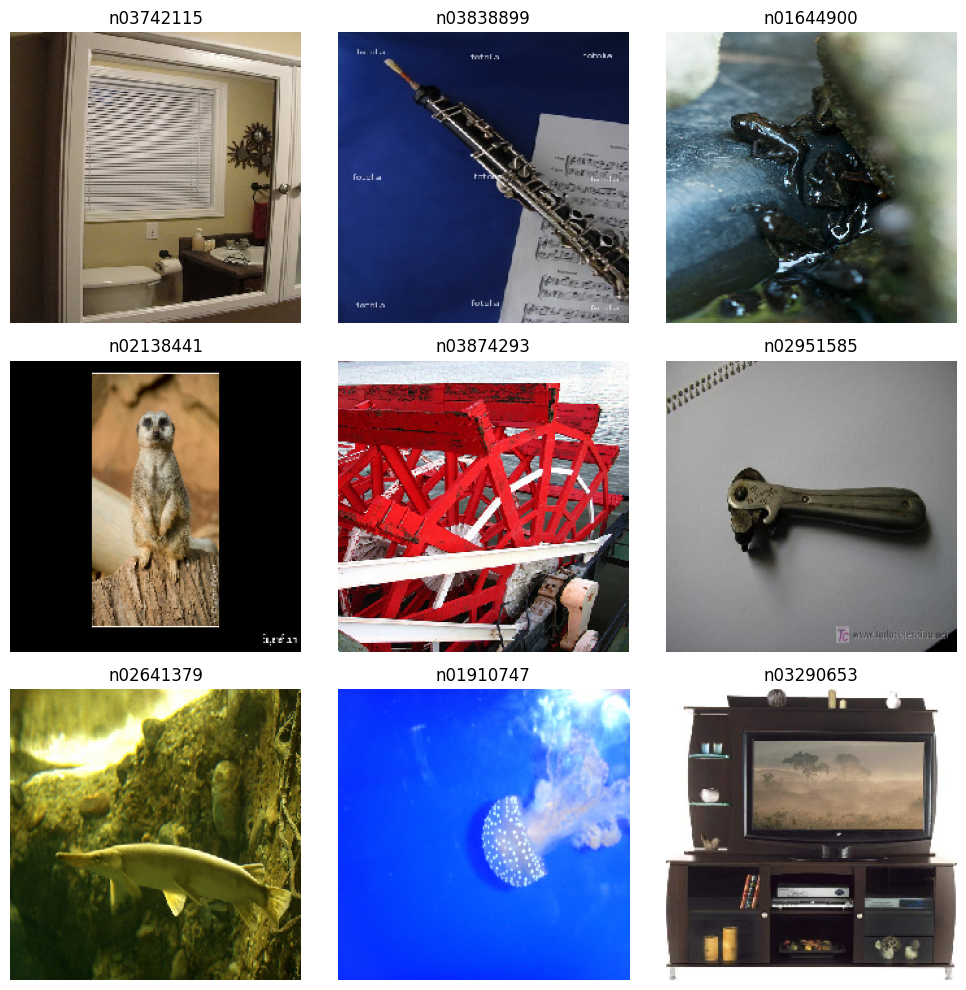

In [26]:
# Affichage d'un batch pour vérifier le prétraitement
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    class_name = list(train_generator.class_indices.keys())[label_idx]
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # Bloc convolutionnel 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Bloc convolutionnel 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Bloc convolutionnel 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),

    # Couche dense
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Couche de sortie
    Dense(train_generator.num_classes, activation='softmax')  # Adaptée au nombre de classes
])


c:\Users\Ordinateur\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [28]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
